<h3>Tarea 7: Modelo de Gray Scott</h3>
<h4>Jua$\eta$ Uri$\epsilon$l L$\epsilon$garia $\pi$$\epsilon$ña</h4>

En esta tarea vamos a tratar de emular el modelo de Gray Scott utilizando autómatas. 

En sí la simulación de wolfram que se muestra en https://www.wolframalpha.com/widgets/gallery/view.jsp?id=540d8e149b5e7de92553fdd7b1093f6d, termina siendo implicitamente una resolución discreta de las ecuaciones diferenciales parciales de Gray Scott, las cuales tienen la siguiente forma:

\begin{align}
&\frac{\partial U}{\partial t} = D_{u}\nabla^2U - UV^2 + F(1-U)\\
&\frac{\partial V}{\partial t} = D_{v}\nabla^2 V  + UV^{2}-(F + k)V
\end{align}

Lo unico que hacemos para el planteamiento con autómatas es definir una regla de actualización usando dichas ecuaciones. 

La idea es que el estado de nuestros autómatas sea descrito por dos cantidades: $U$ y $V$, que son la concentración de los sustratos que reaccionan y se difunden en el modelo.

Nuestra actualización dependerá de algunos parámetros, los cuales explicare brevemente a continuación.

<ul>
    <li>$D_{u}$: Coeficiente de difusión de $U$, en el artículo citado en la pgina de wolfram este tiene un valor de $2\times 10^{-5}$.</li>
    <li>$D_{v}$: Coeficiente de difusión de $V$, en el artículo citado en la página de Wolfram este tiene un valor de $10^{-5}$.</li>
    <li>$F$: Tasa de alimentación de sustrato</li>
    <li>$k$: Tasa de la reacción que genera el producto</li>
</ul>

Bien, ahora definamos la regla de actualización, esta la realizaremos de la siguiente manera:

\begin{align}
\Delta U(i,j) =& D_{u}\left(U(i-1,j)+U(i+1,j) + U(i,j+1) +U(i, j-1)-4U(i,j)\right)\notag \\
-& U(i,j)V(i,j)^2 +F(1-U(i,j))\\
\Delta V(i,j) =& D_{v}\left(V(i-1,j)+V(i+1,j) + V(i,j+1) +V(i, j-1)-4V(i,j)\right)\notag \\
+& U(i,j)V(i,j)^2 -(F+k)V \\ 
U_{+1} = U + &\Delta U \\
V_{+1} = V + &\Delta V
\end{align}

Donde realmente lo unico que hemos hecho es discretizar el Laplaciano.]
Notese que por la forma en que calculamos el Laplaciano se está trabajando con una vecindad de Von Neumann. 






In [5]:
import numpy as np
from enum import Enum
import random
import matplotlib.pyplot as plt
import math
import matplotlib.patches as patches
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from IPython.display import clear_output
from random import randrange
from math import gamma;

In [127]:
class GrayScottParams:
    
    def __init__(self, Du, Dv, F, k):
        self.Du  = Du
        self.Dv = Dv
        self.F = F
        self.k = k
    


class GrayScottWorld:
    
    
    def __init__(self, worldWidth, worldHeight, params):
        """
        Inicializa una rejilla de GrayScott de ancho y altura especificados 
        por el usuario. Se debe dar un objeto de tipo GrayScottParams con los
        parámetros de la simulación.
        """
        
        #Vamos a iniciar nuestras matrices U y V. 
        self.initialU = np.ones((worldHeight, worldWidth))
        self.initialV = np.zeros((worldHeight, worldWidth))
        self.worldWidth = worldWidth
        self.worldHeight = worldHeight
        self.params = params
        
    
    def addPerturbation(self, uValue, vValue, noiseStd):
        
        """
        Añade una perturbación de magnitud dada en el centro del
        mundo también puede añadir algo de ruido a todos los pixeles
        de la rejilla inicial.
        """
        centerX = int(np.floor(self.worldWidth/2))-1
        centerY = int(np.floor(self.worldHeight/2))-1
        centerRadius = 1
        for i in range(-centerRadius,centerRadius +1):
            for j in range(-centerRadius,centerRadius+1):
                self.initialU[centerY+i, centerX+j] = uValue
                self.initialV[centerY+i, centerX+j] = vValue
        self.centerX = centerX
        self.centerY = centerY
        for i in range(1, self.worldHeight-1):
            for j in range(1, self.worldWidth-1):
                self.initialU[i,j] = self.initialU[i,j] + np.random.normal(0,noiseStd)
                self.initialV[i,j] = self.initialV[i,j] + np.random.normal(0,noiseStd)
    
        
    def step(self, i, j, step):
        previousU = self.U[:,:,step - 1]
        previousV = self.V[:,:, step - 1]
        deltaU = self.params.Du*(previousU[i,(j-1)%self.worldWidth] + previousU[i, (j+1)%self.worldWidth] + previousU[(i-1)%self.worldHeight,j] + previousU[(i+1)%self.worldHeight, j]-4*previousU[i,j])-previousU[i,j]*previousV[i,j]**2 +self.params.F*(1-previousU[i,j])
        deltaV = self.params.Dv*(previousV[i,(j-1)%self.worldWidth] + previousV[i,(j+1)%self.worldWidth] + previousV[(i-1)%self.worldHeight,j] +previousV[(i+1)%self.worldHeight,j]-4*previousV[i,j]) + previousU[i,j]*previousV[i,j]**2 -(self.params.F + self.params.k)*previousV[i,j]
        self.U[i,j,step] = self.U[i,j,step-1] + deltaU
        self.V[i,j,step] = self.V[i,j,step-1] + deltaV
        
    def evolve(self, steps):
        """
        Evoluciona el sistema un número especificado de pasos
        """
        self.U = np.zeros((self.worldHeight, self.worldWidth, steps))
        self.U[:,:,0] = self.initialU
        self.V = np.zeros((self.worldHeight, self.worldWidth, steps))
        self.V[:,:,0] = self.initialV
        for s in range(1, steps):
            clear_output(wait = True)
            print(s,flush = True)
            for i in range(0, self.worldHeight):
                for j in range(0, self.worldWidth):
                    self.step(i,j,s)
        print("evolved")
    
    def plotFrame(self, i):
        self.ax.clear()
        self.ax.imshow(self.V[:,:,i], cmap = "plasma")
    
    def buildAnimation(self, seconds):
        self.fig,self.ax = plt.subplots(figsize = (7,7))
        fr = np.size(self.V,2)
        deltaT = (seconds/fr)*1000
        anim = FuncAnimation(self.fig, self.plotFrame, frames = fr, interval = deltaT, blit = False)
        return HTML(anim.to_html5_video())
    
    
        
        
        
        
        
        

In [128]:
#Creamos primero nuestros parámetros de Gray Scott
grayScottParams = GrayScottParams(0.18, 0.08,0.035, 0.065)

In [129]:
#Definimos nuestro mundo difusivo con una perturbación central
size = 40
difussionWorld = GrayScottWorld(size, size, grayScottParams)
perturbationU = 1/4
perturbationV = 1/2
noise = 0.01
difussionWorld.addPerturbation(perturbationU, perturbationV, noise)

In [132]:
#Lo evolucionamos
steps = 10000
difussionWorld.evolve(steps)

9999
evolved


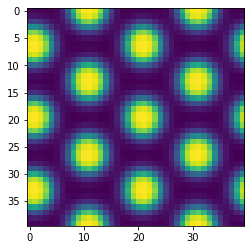

In [133]:
plt.figure()
plt.imshow(difussionWorld.V[:,:,9999])

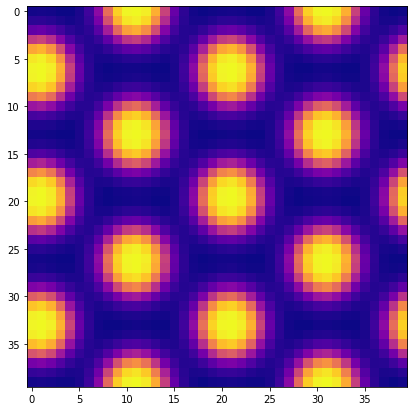

In [135]:
difussionWorld.buildAnimation(120)

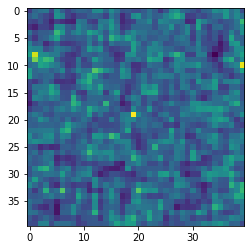

In [55]:
plt.figure()
plt.imshow(difussionWorld.V[:,:,2])

# difussionWorld.V[:,:,7000]

In [45]:
difussionWorld.V[:,:,0]

array([[-0.0984906 ,  0.03269809, -0.00091491, ...,  0.0040774 ,
         0.04334513, -0.01201608],
       [ 0.02031341,  0.02658719, -0.02809934, ..., -0.02300051,
         0.06505706, -0.03049976],
       [-0.06487237, -0.03406036,  0.01918382, ...,  0.00449135,
        -0.02954858,  0.13158958],
       ...,
       [ 0.01446621,  0.03883418,  0.00693953, ..., -0.06966547,
        -0.00921447,  0.02791385],
       [-0.02275156, -0.03961784, -0.04139151, ...,  0.06958235,
         0.02356423,  0.02494548],
       [ 0.02031955, -0.07015726,  0.06156461, ..., -0.03561769,
         0.00455277, -0.05874573]])